# Gate Channels Dynamics
First of all we import the necessaty packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as stats
from scipy.stats import norm
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import math
import time

## Stochastic simulation of a Markov Jump Process
Now we simulate a continuous time Markov jump process with 2 possible states using Gillespie's method.

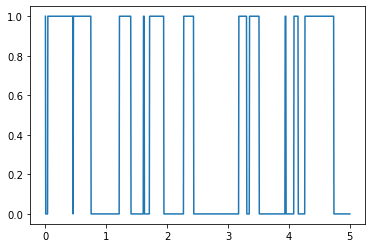

In [2]:
## Simulating one channel with two possible states

def simulate(seed = 1, alpha = 2, beta = 0.5, T_max = 1, fixed_in = False, initial_state = 0,
             space = 1000, show_progress = False, length_size = 1):
    
    ## List of parameters:
    ## - seed: seed to simulate
    ## - alpha, beta: rates
    ## - T_max: obvious
    ## - fixed_in: True if we want to fix the initial state
    ## - initial_state: initial state
    ## - space: numbers of division of the space vector t
    ## - show_progress: True if we want to show progress of the simulation
    ## - length_size: True to rescale it
    
    ## First we define the infinitesimal generator matrix Q of the Markov process
    
    Q = np.array([[-alpha, alpha], # rate of exit from 0, rate jump from 0 to 1
                  [beta, -beta]])  # rate jump from 1 to 0, rate of exit from 1
    
    ## Now we can define the rates of an event (opening or closing of the gate), that are the
    ## elements on the diagonal of Q (in absolute value)
    
    rate = np.array([-Q[0,0], -Q[1,1]])
    
    ## We set the seed in order to generate always the same thing
    
    np.random.seed(seed)
    
    # We define an index for current time
    
    index = 0 # index of current time: t = t[index], S = S[index]

    ## We generate the vector of times (t) and the vector of state at time t S(t) (S = 0 means that
    ## the gate is closed while S = 1 means that the gate is open)
    
    t = np.linspace(0, T_max, space)
    S = np.zeros_like(t)
    
    ## If we want to fix the initial state
    
    if fixed_in:
        S[0] = initial_state
    
    else:
        
        # We initialize S by setting randomly S(0) equal to either 0 or 1
        S[0] = np.random.choice([0,1])

    # If we want to show progress of our method
    
    if show_progress:
        pbar = tqdm(total = space, desc="Progresso")
    else:
        pbar = None
        
    ## Now we update S
    
    while (index < len(t)):

            ## First of all, we generate the switching time, that is exponentially distributed with rate
            ## rate(S(t)) according to Markov assumptions, using Gillespie's method
            
            current_state = int(S[index])
            current_time = t[index]
            unif = np.random.uniform(0, 1)
            
            t1_wait = - (1/rate[current_state]) * np.log(unif) / length_size 
            # The division is to rescale times if we want to have different time scales, 
            # I don't know if it makes any sense here
            
            ## Final time
            t1_tot = t1_wait + current_time
            
            # Now we keep the state fixed up to time t1_tot
            # (or the maximum time that we imposed in T_max that is reached
            # when index index reaches a higher level wrt to the number of steps)

            while (t[index] < t1_tot):
                S[index] = current_state
                index +=1
                if index >= len(t):
                    break
                         
            # Now we update S
            
            if index >= len(t):
                    break
            else:
                ## NOTA: poichè solo due possibili stati, a ogni switch time cambia anche lo stato e diventa l'altro
                ## In caso contrario (n stati), dividi l'unità in n-1 intervalli di lunghezza (q_ij)/q_i, scegli un 
                ## numero casuale tra 0 e 1 e il nuovo stato è il j tale che il numero è nel j-esimo sottointervallino
                ## In questo caso però facciamo così
                S[index] = 1 - current_state
                
            if show_progress:
                pbar.update(1)  # Update progress bar
        
    if show_progress:
        pbar.close()

    return S

# Simulation

T_max1 = 5
S = simulate(seed = 1, alpha = 2, beta = 5, T_max = T_max1, space = 1000, show_progress = False)
t = np.linspace(0, T_max1, 1000) # time

plt.plot(t, S)


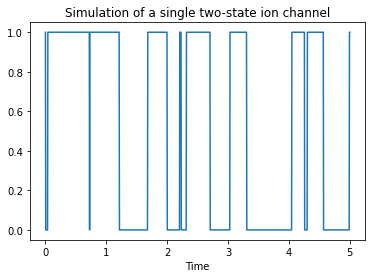

In [3]:
## Simulation of a channel

T_max1 = 5
S = simulate(seed = 1, alpha = 2, beta = 3, T_max = T_max1, space = 1000, show_progress = False)
t = np.linspace(0, T_max1, 1000) # time

plt.figure()
plt.plot(t, S)
plt.xlabel("Time")
plt.title("Simulation of a single two-state ion channel")
plt.show()

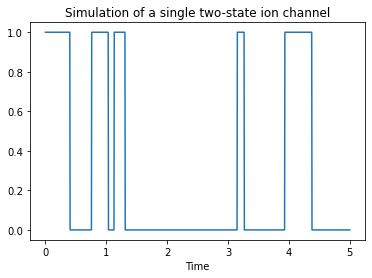

In [4]:
## Simulation of the same channel with a different seed

T_max1 = 5
S = simulate(seed = 10, alpha = 2, beta = 3, T_max = T_max1, space = 1000, show_progress = False)
t = np.linspace(0, T_max1, 1000) # time

plt.figure()
plt.plot(t, S)
plt.xlabel("Time")
plt.title("Simulation of a single two-state ion channel")
plt.show()

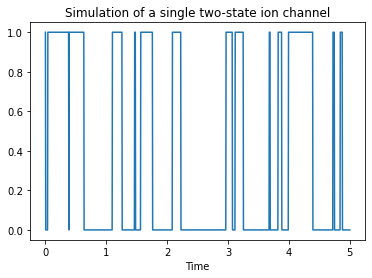

In [5]:
## Simulation of another channel

T_max1 = 5
S = simulate(seed = 1, alpha = 2, beta = 6, T_max = T_max1, space = 1000, show_progress = False)
t = np.linspace(0, T_max1, 1000) # time

plt.figure()
plt.plot(t, S)
plt.xlabel("Time")
plt.title("Simulation of a single two-state ion channel")
plt.show()

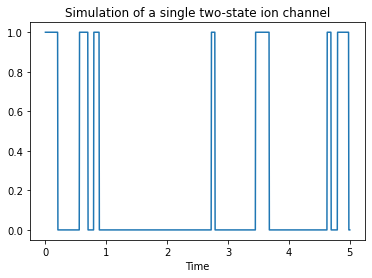

In [6]:
## Simulation of another channel

T_max1 = 5
S = simulate(seed = 10, alpha = 2, beta = 6, T_max = T_max1, space = 1000, show_progress = False)
t = np.linspace(0, T_max1, 1000) # time

plt.figure()
plt.plot(t, S)
plt.xlabel("Time")
plt.title("Simulation of a single two-state ion channel")
plt.show()

Now we define a function to simulate N independent Markov jump processes by setting N different seeds in the previous function.

In [7]:
## Simulating N independent channels

def sim_indep(N = 10, alpha = 2, beta = 3, 
              T_max = 1, space = 1000, show_progress = False, length_size = 1,
              factor = 1):

    t = np.linspace(0, T_max, space)
    S_tot = np.zeros_like(t)

    for n in tqdm(range(N)):
        ## First of all, we simulate the N-th process
        S = simulate(seed = (factor * n), alpha = alpha, beta = beta, T_max = T_max, 
                     space = space, show_progress = show_progress, length_size = length_size)

        ## Then we update the total number of open channels by summing the N-th process to the previous ones
        S_tot = S_tot + S

    # The total fraction of open channel is the number of open channels divided by N
    p = S_tot/N
    
    return p


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2046.81it/s]


Mean:  0.69778
Variance:  0.0011840715999999992
Standard Deviation:  0.03441034146880846


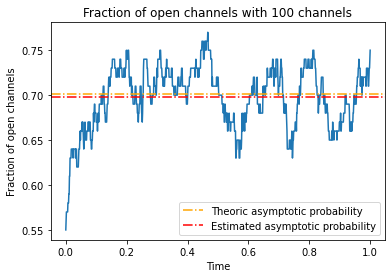

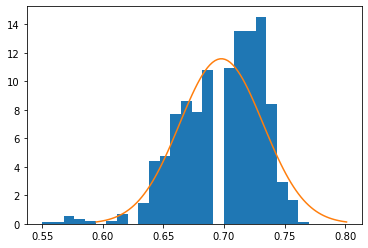

In [8]:
## Fix the values of constants

alpha = 8
beta = 3.4
T_max = 1
space = 1000
t = np.linspace(0, T_max, space)
prob_inv = alpha / (alpha + beta)
N = 100

p = sim_indep(N = 100, alpha = alpha, beta = beta, 
              T_max = T_max, space = space, show_progress = False)

# Let us plot the fraction of open channels
plt.figure()
plt.plot(t,p)
plt.axhline(y = prob_inv, color = 'orange', linestyle = "-.", label = "Theoric asymptotic probability")
plt.axhline(y = np.mean(p), color = 'red', linestyle = "-.", label = "Estimated asymptotic probability")
plt.xlabel("Time")
plt.ylabel("Fraction of open channels")
plt.title(f"Fraction of open channels with {N} channels")
plt.legend()
plt.show

# Let us print also the variance, the mean and the standard deviation of the open channels
print("Mean: ", np.mean(p))
print("Variance: ", np.var(p))
print("Standard Deviation: ", np.std(p))

# Plot of the histograms

plt.figure()

plt.hist(p, bins = 25, density = True)
mu = np.mean(p)
variance = np.var(p)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.show()

Now the idea is to show that the solution converges to the solution to the master equation. If we write the vector of probabilities $\pi(t) = \pi_1(t), \pi_2(t)$ the master equation is given by
$$
\pi'(t) = \pi(t) Q
$$
where $Q$ is the transition rate matrix that we saw above. We define a function that solves this equation.

In [9]:
def master(alpha = 2, beta = 3, initial_cond = np.array([0.5, 0.5]), T_max = 1,
          points = 100):
    
    ## Define matrix Q
    Q = np.array([[-alpha, alpha],
                  [beta,  -beta]])

    ## ODE function: y' = y*Q (which is the same as y' = Q^t y in 2.199)
    
    def system(t, y):
        return y @ Q  # Outer product

    ## Time interval
    t_span = (0, T_max)
    t_eval = np.linspace(*t_span, points) 

    ## Solve the ODE system
    sol = solve_ivp(system, t_span, initial_cond, t_eval=t_eval, method='RK45')
    
    return sol

We want now to generate more simulation of the quantity $p(t)$, in particular $M$ simulations with $N$ channels and see that this quantity converges to the solution to the master equation.

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2088.71it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

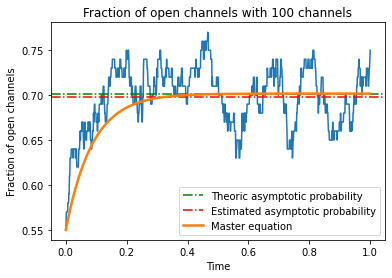

In [10]:
## First we try with just 1 simulation of N channels

alpha = 8
beta = 3.4
T_max = 1
space = 1000
t = np.linspace(0, T_max, space)
prob_inv = alpha / (alpha + beta)

p_1 = sim_indep(N = 100, alpha = alpha, beta = beta, 
              T_max = T_max, space = space, show_progress = False)

## Now solve the master equation with the same initial conditions as the simulation before, i.e.,
## we need to extrapolate them from the data of p_1

# Initial condition

p1 = p_1[0]
p0 = 1 - p1
y0 = np.array([p0, p1])

sol = master(alpha = alpha, beta = beta, initial_cond = y0, T_max = T_max, points = 1000)

# Let us plot the fraction of open channels and the solution to this problem
plt.figure()
plt.plot(t,p_1)
plt.axhline(y = prob_inv, color = 'green', linestyle = "-.", label = "Theoric asymptotic probability")
plt.axhline(y = np.mean(p), color = 'red', linestyle = "-.", label = "Estimated asymptotic probability")
plt.plot(sol.t, sol.y[1], label = "Master equation", linewidth = 2.5)
plt.xlabel("Time")
plt.ylabel("Fraction of open channels")
plt.title(f"Fraction of open channels with {N} channels")
plt.legend()
plt.show


This looks quite good. Now we want to simulate more times the same number of channels to see how it behaves.

In [11]:
def sim_many(M = 10, N = 10, alpha = 2, beta = 3, 
             T_max = 1, space = 1000, show_progress = False, length_size = 1, final_pos = -1):
    
    ## M: number of times we repeat the simulation
    ## N: number of independent channels

    p_tot = []
    p_fin = []
    p0_in = []

    for q in tqdm(range(M)):
        
        ## We compute again the simulation for simplicity
        S_tot = np.zeros_like(t)
        
        ## Impose randomness by setting the seed to have the same result
        
        np.random.seed(q)

        rand = np.random.randint(0, N)

        for n in (range(N)):
            # First of all, we simulate the N-th process
            S = simulate(seed = rand * n, alpha = alpha, beta = beta, T_max = T_max, 
                         space = space, show_progress = False, length_size = 1)

            # Then we update the total number of open channels by summing the N-th process to the previous ones
            S_tot = S_tot + S

        # The total fraction of open channel is the number of open channels divided by N
        p = S_tot/N
        p_tot.append(p)
        p_fin.append(p[final_pos])
        p0_in.append(p[0])
        
    p1 = np.mean(p0_in)
        
    return p_tot, p_fin, p1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.42it/s]


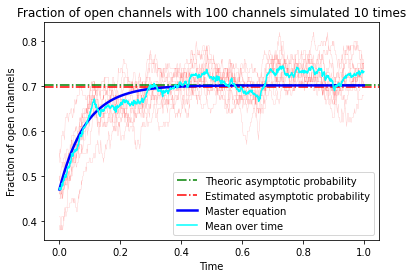

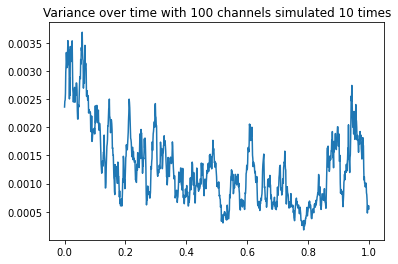

Mean:  0.732
Variance:  0.0005959999999999999
Standard Deviation:  0.024413111231467402
Theoretical result:  0.7017315755652219


In [12]:
## Prove with some quantities

alpha = 8
beta = 3.4
T_max = 1
space = 1000
t = np.linspace(0, T_max, space)
prob_inv = alpha / (alpha + beta)

M = 10
N = 100
final_pos = -1

p_tot1, p_fin1, p1_1 = sim_many(M = M, N = N, alpha = alpha, beta = beta, 
                          T_max = T_max, space = space, show_progress = False, 
                          length_size = 1, final_pos = final_pos)

## Compute mean and variance over time

p_tot_mean = np.mean(p_tot1, axis = 0)
p_tot_var = np.var(p_tot1, axis = 0)

## Now solve the master equation: we need the initial condition

# Initial condtion

p1 = p1_1
p0 = 1 - p1
y0 = np.array([p0, p1])

sol1 = master(alpha = alpha, beta = beta, initial_cond = y0, T_max = T_max, points = 1000)

# Let us plot the fraction of open channels and the solution to this problem
plt.figure()
for i in range(M):
    plt.plot(t, p_tot1[i], linewidth = 0.3, color = 'red', alpha = 0.3)
plt.axhline(y = prob_inv, color = 'green', linestyle = "-.", label = "Theoric asymptotic probability")
plt.axhline(y = np.mean(p), color = 'red', linestyle = "-.", label = "Estimated asymptotic probability")
plt.plot(sol1.t, sol1.y[1], label="Master equation", color = 'blue', linewidth = 2.5)
plt.plot(t, p_tot_mean, label = "Mean over time", color = 'cyan', linewidth = 1.5)
plt.xlabel("Time")
plt.ylabel("Fraction of open channels")
plt.title(f"Fraction of open channels with {N} channels simulated {M} times")
plt.legend()
plt.show

## Plot of variance
plt.figure()
plt.plot(t, p_tot_var)
plt.title(f"Variance over time with {N} channels simulated {M} times")
plt.show()

## Evaluate mean and variance of the final_pos value
print("Mean: ", np.mean(p_fin1))
print("Variance: ", np.var(p_fin1))
print("Standard Deviation: ", np.std(p_fin1))
print("Theoretical result: ", sol1.y[1, final_pos])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.40it/s]


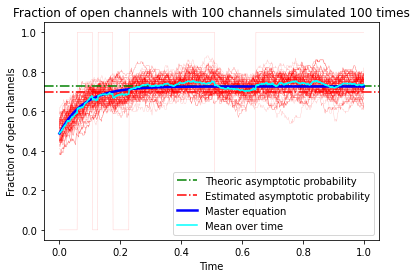

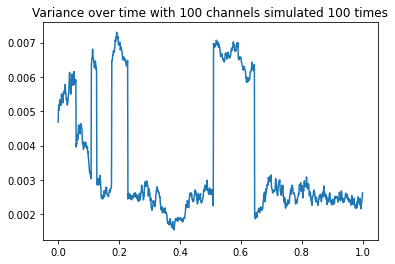

Mean:  0.7349
Variance:  0.0026229900000000017
Standard Deviation:  0.05121513448190878
Theoretical result:  0.7257974594098375


In [13]:
## Prove with some quantities

alpha = 9
beta = 3.4
T_max = 1
space = 1000
t = np.linspace(0, T_max, space)
prob_inv = alpha / (alpha + beta)

M = 100
N = 100
final_pos = -1

p_tot1, p_fin1, p1_1 = sim_many(M = M, N = N, alpha = alpha, beta = beta, 
                          T_max = T_max, space = space, show_progress = False, 
                          length_size = 1, final_pos = final_pos)

## Compute mean and variance over time

p_tot_mean = np.mean(p_tot1, axis = 0)
p_tot_var = np.var(p_tot1, axis = 0)

## Now solve the master equation: we need the initial condition

# Initial condtion

p1 = p1_1
p0 = 1 - p1
y0 = np.array([p0, p1])

sol1 = master(alpha = alpha, beta = beta, initial_cond = y0, T_max = T_max, points = 1000)

# Let us plot the fraction of open channels and the solution to this problem
plt.figure()
for i in range(M):
    plt.plot(t, p_tot1[i], linewidth = 0.3, color = 'red', alpha = 0.3)
plt.axhline(y = prob_inv, color = 'green', linestyle = "-.", label = "Theoric asymptotic probability")
plt.axhline(y = np.mean(p), color = 'red', linestyle = "-.", label = "Estimated asymptotic probability")
plt.plot(sol1.t, sol1.y[1], label="Master equation", color = 'blue', linewidth = 2.5)
plt.plot(t, p_tot_mean, label = "Mean over time", color = 'cyan', linewidth = 1.5)
plt.xlabel("Time")
plt.ylabel("Fraction of open channels")
plt.title(f"Fraction of open channels with {N} channels simulated {M} times")
plt.legend()
plt.show

## Plot of variance
plt.figure()
plt.plot(t, p_tot_var)
plt.title(f"Variance over time with {N} channels simulated {M} times")
plt.show()

## Evaluate mean and variance of the final_pos value
print("Mean: ", np.mean(p_fin1))
print("Variance: ", np.var(p_fin1))
print("Standard Deviation: ", np.std(p_fin1))
print("Theoretical result: ", sol1.y[1, final_pos])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.51it/s]


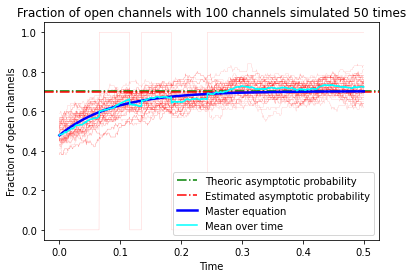

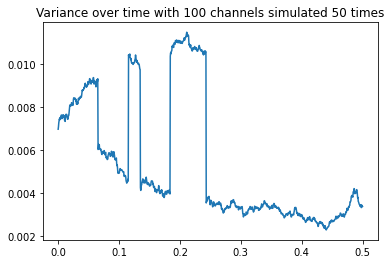

Mean:  0.5604
Variance:  0.00907584
Standard Deviation:  0.09526720317087092
Theoretical result:  0.575636368961968


In [14]:
## Prove with some quantities

alpha = 8
beta = 3.4
T_max = 0.5
space = 1000
t = np.linspace(0, T_max, space)
prob_inv = alpha / (alpha + beta)

M = 50
N = 100
final_pos = 100

p_tot1, p_fin1, p1_1 = sim_many(M = M, N = N, alpha = alpha, beta = beta, 
                          T_max = T_max, space = space, show_progress = False, 
                          length_size = 1, final_pos = final_pos)

## Compute mean and variance over time

p_tot_mean = np.mean(p_tot1, axis = 0)
p_tot_var = np.var(p_tot1, axis = 0)

## Now solve the master equation: we need the initial condition

# Initial condtion

p1 = p1_1
p0 = 1 - p1
y0 = np.array([p0, p1])

sol1 = master(alpha = alpha, beta = beta, initial_cond = y0, T_max = T_max, points = 1000)

# Let us plot the fraction of open channels and the solution to this problem
plt.figure()
for i in range(M):
    plt.plot(t, p_tot1[i], linewidth = 0.3, color = 'red', alpha = 0.3)
plt.axhline(y = prob_inv, color = 'green', linestyle = "-.", label = "Theoric asymptotic probability")
plt.axhline(y = np.mean(p), color = 'red', linestyle = "-.", label = "Estimated asymptotic probability")
plt.plot(sol1.t, sol1.y[1], label="Master equation", color = 'blue', linewidth = 2.5)
plt.plot(t, p_tot_mean, label = "Mean over time", color = 'cyan', linewidth = 1.5)
plt.xlabel("Time")
plt.ylabel("Fraction of open channels")
plt.title(f"Fraction of open channels with {N} channels simulated {M} times")
plt.legend()
plt.show

## Plot of variance
plt.figure()
plt.plot(t, p_tot_var)
plt.title(f"Variance over time with {N} channels simulated {M} times")
plt.show()

## Evaluate mean and variance of the final_pos value
print("Mean: ", np.mean(p_fin1))
print("Variance: ", np.var(p_fin1))
print("Standard Deviation: ", np.std(p_fin1))
print("Theoretical result: ", sol1.y[1, final_pos])

The idea is to find an N such that the variance is high. We should keep low values.

100%|███████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 201.17it/s]


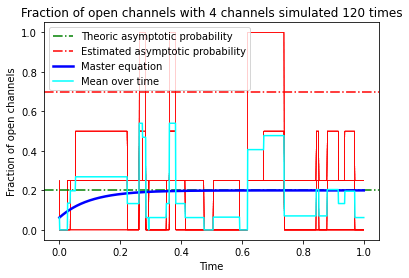

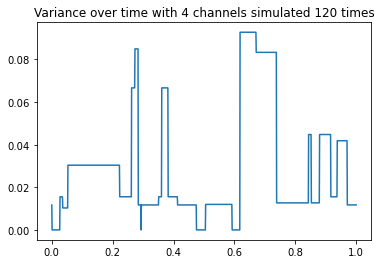

Mean:  0.26875
Variance:  0.030377604166666666
Standard Deviation:  0.17429172145189992
Theoretical result:  0.14948535595490162


In [15]:
## Prove with some quantities

alpha = 2
beta = 8
T_max = 1
space = 1000
t = np.linspace(0, T_max, space)
prob_inv = alpha / (alpha + beta)

M = 120
N = 4
final_pos = 100

p_tot1, p_fin1, p1_1 = sim_many(M = M, N = N, alpha = alpha, beta = beta, 
                          T_max = T_max, space = space, show_progress = False, 
                          length_size = 1, final_pos = final_pos)

## Compute mean and variance over time

p_tot_mean = np.mean(p_tot1, axis = 0)
p_tot_var = np.var(p_tot1, axis = 0)

## Now solve the master equation: we need the initial condition

# Initial condtion

p1 = p1_1
p0 = 1 - p1
y0 = np.array([p0, p1])

sol1 = master(alpha = alpha, beta = beta, initial_cond = y0, T_max = T_max, points = 1000)

## Let us plot the fraction of open channels and the solution to this problem
plt.figure()
for i in range(M):
    plt.plot(t, p_tot1[i], linewidth = 0.3, color = 'red', alpha = 0.3)
plt.axhline(y = prob_inv, color = 'green', linestyle = "-.", label = "Theoric asymptotic probability")
plt.axhline(y = np.mean(p), color = 'red', linestyle = "-.", label = "Estimated asymptotic probability")
plt.plot(sol1.t, sol1.y[1], label="Master equation", color = 'blue', linewidth = 2.5)
plt.plot(t, p_tot_mean, label = "Mean over time", color = 'cyan', linewidth = 1.5)
plt.xlabel("Time")
plt.ylabel("Fraction of open channels")
plt.title(f"Fraction of open channels with {N} channels simulated {M} times")
plt.legend()
plt.show

## Plot of variance
plt.figure()
plt.plot(t, p_tot_var)
plt.title(f"Variance over time with {N} channels simulated {M} times")
plt.show()

## Evaluate mean and variance of the final_pos value
print("Mean: ", np.mean(p_fin1))
print("Variance: ", np.var(p_fin1))
print("Standard Deviation: ", np.std(p_fin1))
print("Theoretical result: ", sol1.y[1, final_pos])

## Drugs and Channels
Let us work with TTX: this blocks a a fraction 1-P of the channels, and P is large. Let us see how the current modifies.

**NOTA**: va sistemata con le funzioni che ho fatto questa parte. Secondo me potremmo fermarci qua come esempi.

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.82it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean:  0.7222000000000002
Variance:  0.01199716
Standard Deviation:  0.10953154796678444
Theoretical result:  0.75


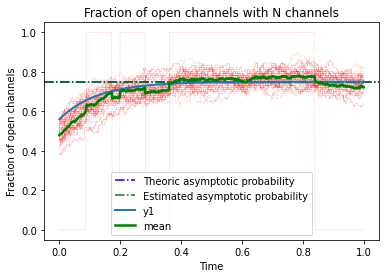

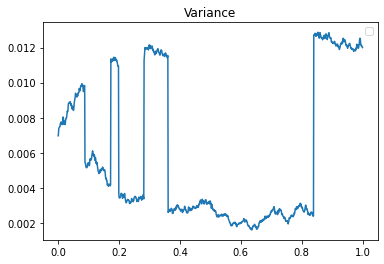

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.54it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

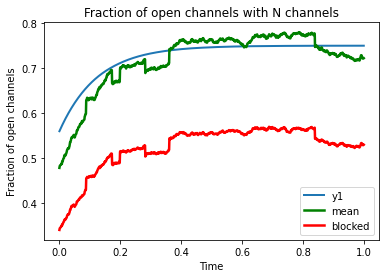

In [16]:
## Simulating N channels

alpha = 6
beta = 2
T_max = 1
space = 1000
t = np.linspace(0, T_max, space)
prob = alpha / (alpha + beta)

M = 50
N = 100

p_tot = []
p_fin = []

for q in tqdm(range(M)):

    S_tot = np.zeros_like(t)
    
    np.random.seed(q)
    
    rand = np.random.randint(0, N)

    for n in (range(N)):
        # First of all, we simulate the N-th process
        S = simulate(seed = rand * n, alpha = alpha, beta = beta, T_max = T_max, 
                     space = space, show_progress = False, length_size = 1)

        # Then we update the total number of open channels by summing the N-th process to the previous ones
        S_tot = S_tot + S

    # The total fraction of open channel is the number of open channels divided by N
    p = S_tot/N
    p_tot.append(p)
    p_fin.append(p[-1])

# Let us print also the variance, the mean and the standard deviation of the open channels
print("Mean: ", np.mean(p_fin))
print("Variance: ", np.var(p_fin))
print("Standard Deviation: ", np.std(p_fin))
print("Theoretical result: ", prob)


# Now solve the master equation

# Initial condtion

p1 = p[0]
p0 = 1 - p1
y0 = np.array([p0, p1])

sol = master(alpha = alpha, beta = beta, initial_cond = y0, T_max = T_max, points = 1000)

### Try to plot also the mean value for any time and see how it goes
p_mean = np.mean(p_tot, axis = 0)
p_var = np.var(p_tot, axis = 0)

# Let us plot the fraction of open channels and the solution to this problem
plt.figure()
for i in range(M):
    plt.plot(t, p_tot[i], linewidth = 0.3, color = 'red', alpha = 0.3)
plt.axhline(y = prob, color = 'blue', linestyle = "-.", label = "Theoric asymptotic probability")
plt.axhline(y = np.mean(p), color = 'green', linestyle = "-.", label = "Estimated asymptotic probability")
plt.plot(sol.t, sol.y[1], label="y1", linewidth = 2)
plt.plot(t, p_mean, color = 'green', linewidth = 2.5, label = 'mean')
plt.xlabel("Time")
plt.ylabel("Fraction of open channels")
plt.title("Fraction of open channels with N channels")
plt.legend()
plt.show

## Plot for the variance
plt.figure()
plt.plot(t, p_var)
plt.title("Variance")
plt.legend()
plt.show()

## Now add the component of the drug
P = 0.7       # percentual of available channels
p_block = []

for q in tqdm(range(M)):

    S_tot = np.zeros_like(t)
    
    np.random.seed(q)
    
    rand = np.random.randint(0, N)

    for n in (range(N)):
        # We simulate the N-th process only if the channel is not blocked, so with probability
        # P it is blocked
        np.random.seed(n)
        
        ## Generate a random number with prob. P to be 1 (and so to work) and 1-P to be blocked 
        work = np.random.binomial(1, P, 1)
        
        if work==1:    # only if it is not blocked
            S = simulate(seed = rand * n, alpha = alpha, beta = beta, T_max = T_max, 
                     space = space, show_progress = False, length_size = 1)
            
            S_tot = S_tot + S

        # Then we update the total number of open channels by summing the N-th process to the previous ones
        

    # The total fraction of open channel is the number of open channels divided by N
    p_blok = S_tot/N
    p_block.append(p_blok)
    
### Try to plot also the mean value for any time and see how it goes
p_mean_block = np.mean(p_block, axis = 0)
p_var_block = np.var(p_block, axis = 0)

# Let us plot the fraction of open channels and the solution to this problem
plt.figure()
# for i in range(M):
#     plt.plot(t, p_tot[i], linewidth = 0.3, color = 'red', alpha = 0.3)
# plt.axhline(y = prob, color = 'blue', linestyle = "-.", label = "Theoric asymptotic probability")
# plt.axhline(y = np.mean(p), color = 'green', linestyle = "-.", label = "Estimated asymptotic probability")
plt.plot(sol.t, sol.y[1], label="y1", linewidth = 2)
plt.plot(t, p_mean, color = 'green', linewidth = 2.5, label = 'mean')
plt.plot(t, p_mean_block, color = 'red', linewidth = 2.5, label = 'blocked')
plt.xlabel("Time")
plt.ylabel("Fraction of open channels")
plt.title("Fraction of open channels with N channels")
plt.legend()
plt.show

### DA FARE
Finire di sistemare e trovare dati buoni per ottenere buoni risultati.